In [17]:
# Import OS module
import os

# Imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Notebook magic
%matplotlib inline

In [18]:
# Check if GPU available
!nvidia-smi

Sun Apr 21 19:54:22 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.06       Driver Version: 522.06       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   58C    P8     3W /  N/A |   3931MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
# Configure variables for Transfer learning
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
grid_shape = (1, image_size, image_size, 3)

batch_size = 32

## Load Image data

We will be loading all the images in the dataset and apply augmentations to make the model prepared for all kinds of images.

The Tensorflow and Keras API provides `ImageDataGenerator` for adding the augmentations to be applied to the images, and easily load them from the directory. This automatically keeps track of the class for each image and works seamlessly with the rest of the API.

In [20]:
dataset_root = "D:/Datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_root, "train")
test_dir = os.path.join(dataset_root, "valid")

In [21]:
# Define augmentations for train dataset and read the images
train_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0,
    # Filling for W/H shift
    fill_mode="nearest",
    # Width and Height shift
    width_shift_range=0.2,
    height_shift_range=0.2,
    # Random zooms
    zoom_range=0.2,
    # Random Shearing aug
    shear_range=0.2,
)

# Read data from directory
train_data = train_aug.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 70295 images belonging to 38 classes.


In [22]:
# Get the list of categories in training data
cats = list(train_data.class_indices.keys())

In [23]:
# Augmentations for test data
test_aug = ImageDataGenerator(
    # Rescale
    rescale=1/255.0
)

# Read data from directory
test_data = test_aug.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode="categorical"
)

Found 17572 images belonging to 38 classes.


In [24]:
# Load the base model
mbnet_v2 = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=input_shape
)

# Stop from being trainable
mbnet_v2.trainable = False

In [25]:
# Define the layers
inputs = keras.Input(shape=input_shape)

# Get the layer
x = mbnet_v2(inputs, training = False)

# Stack layers further
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(cats), activation="softmax")(x)

# Combine the model
model = Model(inputs=inputs, outputs=x)

# Summary
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


In [26]:
# Compile
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define callbacks to use
early_stopping_cb = callbacks.EarlyStopping(monitor="loss", patience=3)

In [27]:
# Num epochs
epochs = 30

# Train model
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=150,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
150/150 [==============================] - 225s 1s/step - loss: 1.9336 - accuracy: 0.4885
Epoch 2/30
150/150 [==============================] - 192s 1s/step - loss: 0.8720 - accuracy: 0.7508
Epoch 3/30
150/150 [==============================] - 174s 1s/step - loss: 0.6435 - accuracy: 0.8202
Epoch 4/30
150/150 [==============================] - 165s 1s/step - loss: 0.5781 - accuracy: 0.8304
Epoch 5/30
150/150 [==============================] - 155s 1s/step - loss: 0.5160 - accuracy: 0.8448
Epoch 6/30
150/150 [==============================] - 154s 1s/step - loss: 0.4807 - accuracy: 0.8537
Epoch 7/30
150/150 [==============================] - 135s 901ms/step - loss: 0.4264 - accuracy: 0.8671
Epoch 8/30
150/150 [==============================] - 160s 1s/step - loss: 0.3968 - accuracy: 0.8815
Epoch 9/30
150/150 [==============================] - 127s 846ms/step - loss: 0.3860 - accuracy: 0.8735
Epoch 10/30
150/150 [==============================] - 113s 753ms/step - loss: 0.3816

In [28]:
model.evaluate(test_data)

550/550 [==============================] - 162s 292ms/step - loss: 0.2871 - accuracy: 0.9083


[0.2871294915676117, 0.9082631468772888]

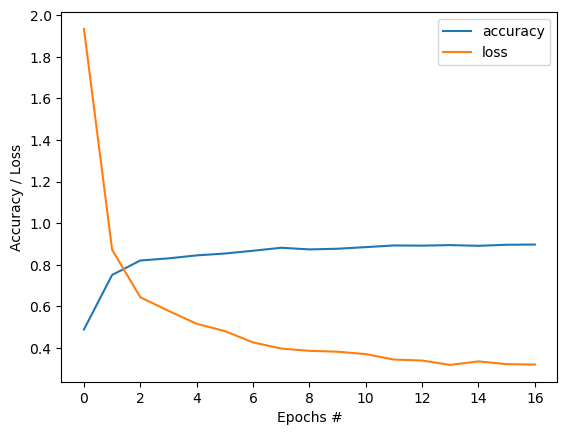

In [29]:
# Plotting
hist = history.history

# Plot accuracy and loss
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["loss"], label="loss")

if "val_accuracy" in hist and "val_loss" in hist:
    plt.plot(hist["val_accuracy"], label="val_accuracy")
    plt.plot(hist["val_loss"], label="val_loss")

# Add the labels and legend
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epochs #")
plt.legend()

# Finally show the plot
plt.show()

In [30]:
model.save("plant_disease_detection.h5")

c:\Users\mdsaz\.conda\envs\likhon\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [31]:
import json

from IPython.display import FileLink

# Link the files
FileLink("./plant_disease_detection.h5")

d:\Downloads\plant_disease_detection.h5

In [32]:
# Dump the categories
with open("categories.json", "w") as file:
  json.dump(train_data.class_indices, file)

# Link categories JSON
FileLink("categories.json")

d:\Downloads\categories.json